# Load and clean data

This notebook will exclusively deal with loading and cleaning the data for Gun Violence project.
<br>
Data will be scraped from <a href="https://www.gunviolencearchive.org/mass-shooting">Gun Violence Archive</a>

<u>Other Datset</u>
- may want to download shapefile to view gun violence on a map (see rmd for example)
- Hash table with states or county geoid for joining?
- some sort of census data that can showcase demographic variables in conjuntion with gun violence
- up close perhaps zip code tabulation areas of 3 metro cities i.e. nyc, chicago and la
- data on states gun laws

In [60]:
# import packages
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
from census import Census
from us import states
import pickle

# import functions
import sys
sys.path.append("..")
from src import *

# filter out warnings
import warnings
warnings.filterwarnings('ignore')

In [108]:
def clean_cols(df):
    df.columns = [x.lower().replace(" ","_") for x in df.columns]
    return df

# Download data

## Census data

Pull in census API key and set to variable
<br>
Grab population by state from 2020 acs 5 year estimate

In [21]:
# Set API key
c = Census(CENSUS_API, year=2020)

In [44]:
# get population by state
us_census = c.acs5.state(('NAME', 'B01003_001E'),state_fips="*")

In [47]:
# create df
us_census_df = pd.DataFrame(us_census)

# preview
us_census_df.head()

,NAME,B01003_001E,state
0,Pennsylvania,12794885.0,42
1,California,39346023.0,06
2,West Virginia,1807426.0,54
3,Utah,3151239.0,49
4,New York,19514849.0,36


In [49]:
# rename column
us_census_df.rename(columns={"NAME":"state","B01003_001E":"Population","state":"state_fips"},
                   inplace=True)

In [111]:
# clean columns
us_census_df = clean_cols(us_census_df)

## Shapefile

Get US Shapefile from <a href="https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html">Census.gov</a>

In [52]:
# download shapfile
us_shp=gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip")

In [110]:
# clean columns
us_shp = clean_cols(us_shp)

In [106]:
# set crs
us_shp.to_crs(4326, inplace=True)

In [100]:
# create drop list
drop_list = ["American Samoa","Guam","Commonwealth of the Northern Mariana Islands",
             "United States Virgin Islands","Puerto Rico","Hawaii","Alaska"]

# drop uncessary territories
us_shp = us_shp[~us_shp["name"].isin(drop_list)]

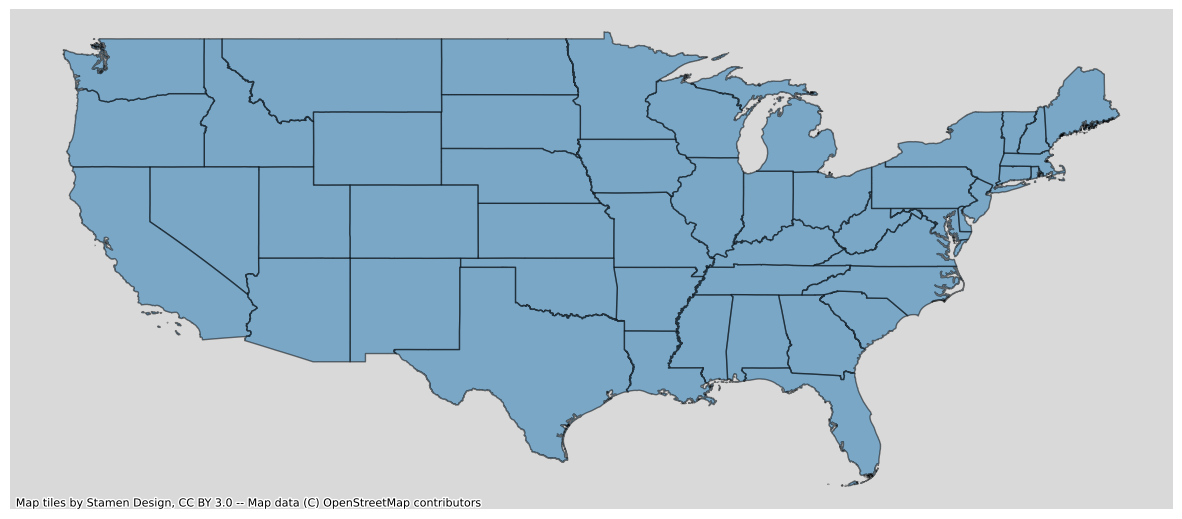

In [107]:
# add ax with .plot()
ax = us_shp.plot(figsize=(15,15), alpha=0.5, edgecolor='k')

# add basemap with contextily
# set basemap to tile to TonerLite
ctx.add_basemap(ax=ax,source=ctx.providers.Stamen.TonerLite) 

# turn off axis
ax.set_axis_off() 

In [101]:
# view states
us_shp["name"].sort_values(ascending=True)

35                 Alabama
39                 Arizona
4                 Arkansas
37              California
24                Colorado
38             Connecticut
6                 Delaware
29    District of Columbia
30                 Florida
12                 Georgia
17                   Idaho
42                Illinois
21                 Indiana
34                    Iowa
11                  Kansas
27                Kentucky
50               Louisiana
51                   Maine
2                 Maryland
55           Massachusetts
36                Michigan
14               Minnesota
13             Mississippi
16                Missouri
26                 Montana
23                Nebraska
31                  Nevada
15           New Hampshire
22              New Jersey
8               New Mexico
25                New York
54          North Carolina
5             North Dakota
52                    Ohio
20                Oklahoma
44                  Oregon
19            Pennsylvania
4

## Gun Violence data

In [113]:
# import data
# have to update selenium py file to save as current date
df = pd.read_csv("./data/export-cfdc8ebc-e01e-4054-a000-e19841ae9e56.csv",
                parse_dates=['Incident Date'])

# clean columns
df = clean_cols(df)

# preview
df.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured,operations
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1,NaN
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3,NaN
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4,NaN
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4,NaN
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4,NaN


### Missing values, shape, dtypes

In [57]:
# look at null values and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   incident_id     2000 non-null   int64         
 1   incident_date   2000 non-null   datetime64[ns]
 2   state           2000 non-null   object        
 3   city_or_county  2000 non-null   object        
 4   address         1990 non-null   object        
 5   #_killed        2000 non-null   int64         
 6   #_injured       2000 non-null   int64         
 7   operations      0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 125.1+ KB


**Null**
<br>
Looks like some null values in the `address` column.
<br>
All `operations` column is null
<br>
<br>
**Shape**
<br>
2000 rows with 8 columns
<br>
<br>
**Dtypes**
<br>
- `incident_id`, `#_killed` and `#_injured` is int64 dtype
- `incident_date` as datetime
- `state`, `city_or_country` and `address` are object
- `operations` is float, but its all null

In [78]:
counter = 0
for x in df["state"].unique():
    print(counter, x)
    counter += 1
    

0 Illinois
1 Arizona
2 Michigan
3 Louisiana
4 New York
5 Georgia
6 Texas
7 Florida
8 Alabama
9 California
10 Maryland
11 Pennsylvania
12 Virginia
13 Oklahoma
14 Colorado
15 Mississippi
16 Nebraska
17 North Carolina
18 New Jersey
19 Tennessee
20 Kansas
21 South Carolina
22 Ohio
23 Missouri
24 Wisconsin
25 Massachusetts
26 Arkansas
27 Oregon
28 Kentucky
29 District of Columbia
30 Washington
31 Indiana
32 Nevada
33 Minnesota
34 New Mexico
35 Delaware
36 Connecticut
37 Iowa
38 South Dakota
39 Idaho
40 West Virginia
41 Rhode Island
42 New Hampshire
43 Alaska
44 Utah
45 Maine
46 Montana


In [ ]:
# drop operations
df.drop(columns="operations", inplace=True)

Datset seems pretty clean, need to scan it for odd erroneous values that will most likely come to light in visual EDA.

In [ ]:
# pickle dataset
df.to_pickle('./data/df')